In [1]:
# API ACCESS & KEY INFO

# INSERT PERSONAL KEYS HERE

Key = 
Secret_Key = 
Bearer_Token = 

SyntaxError: invalid syntax (<ipython-input-1-db90cea78079>, line 5)

In [200]:
# IMPORT LIBS

import tweepy
from tweepy import OAuthHandler
from textblob import TextBlob

import re

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer, WordNetLemmatizer

import pandas as pd
import json
import pprint

import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BennettCelichowski\AppData\Roaming\nltk_data.
[nltk_data]     ..
[nltk_data]   Package stopwords is already up-to-date!


In [126]:
# CREATE OAUTH HANDLER OBJECT

try:
    auth = tweepy.OAuthHandler(Key, Secret_Key)
    api = tweepy.API(auth, parser=tweepy.parsers.JSONParser(), wait_on_rate_limit=True,
    wait_on_rate_limit_notify=True)
except:
    print('Authentification Error')




In [219]:
# SET UP QUERY

query = ('Zach Wilson AND filter:verified AND -filter:replies AND -filter:videos AND -filter:images AND -filter:Links AND -filter:nativeretweets AND -filter:news')

num_tweets = 10000

API = api.search(q = query, count = num_tweets, lang = 'en')





In [279]:
# PARSE OUT DATA INTO A DATAFRAME

output = []


for tweet in API['statuses']:
    

    text = tweet['text']
    favorite_count = tweet['favorite_count']
    retweet_count = tweet['retweet_count']
    date = tweet['created_at']
    verified = tweet['user']['verified']
    name = tweet['user']['name']
    Screen_name = tweet['user']['screen_name']  
    Follower_cnt = tweet['user']['followers_count']
    User_desc = tweet['user']['description']

    hash_lst = []
    for x in tweet['entities']['hashtags']:
        hash_lst.append(x['text'])
    
    Hashtags = hash_lst

    line = {'Text' : text,
    'Favorite_count' : favorite_count,
    'Retweet_count' : retweet_count,
    'Date' :  date,
    "Verified" : verified,
    "Name" : name,
    "Screen Name" : Screen_name,
    "Followers" : Follower_cnt,
    "Hashtags" : Hashtags,
    "User_Desc" : User_desc}
    output.append(line)


Tweet_DF = pd.DataFrame(output)

Tweet_DF.head()

,Text,Favorite_count,Retweet_count,Date,Verified,Name,Screen Name,Followers,Hashtags,User_Desc
0,".@deseretdoug: Please, Jets, give Zach Wilson ...",2,0,Tue Apr 13 17:30:00 +0000 2021,True,Deseret News,DeseretNews,108163,[NFLDraft],"The Deseret News offers news, information, com..."
1,According to @betonline_ag Zach Wilson is 80:1...,2,0,Tue Apr 13 16:52:43 +0000 2021,True,Kristian Dyer,KristianRDyer,12048,"[Jets, JetsTwitter]",NFL Draft Bible on @SINow. #Jets #RBNY #RFootb...
2,LOVE the decisions being made by the Social Me...,995,24,Tue Apr 13 15:47:09 +0000 2021,True,Pat McAfee,PatMcAfeeShow,2053581,[],Award winning wrestler. Kicked off a SuperBowl...
3,Mel Kiper’s latest mock draft for ESPN has the...,855,50,Tue Apr 13 12:17:13 +0000 2021,True,Brian Costello,BrianCoz,49919,[],New York Jets beat reporter for the New York P...
4,New York Jets’ 2021 NFL Draft headquarters: Af...,0,0,Tue Apr 13 02:16:33 +0000 2021,True,The Athletic New York,TheAthleticNYC,15268,[],Here for every sports story that matters. \n📲 ...


In [280]:
# CLEAN TWEET DATA

stop_words = stopwords.words('english')
Addl_StopWords = map(lambda x : x.lower(),['BYU', 'Zach', 'Wilson', 'College', 'NFL', 'Draft', 'pick', 'http', 'co', 'football'])
for word in Addl_StopWords:
    stop_words.append(word)

#print(stopwords)

# STEMMER & LEMMATIZER
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# CLEAN TWEET TEXT

clean_data = []

for word in range(len(Tweet_DF['Text'])):
    #REMOVE PUNCTUATION
    tweet = re.sub('[^a-zA-Z]',' ',Tweet_DF['Text'].iloc[word])
    #MAKE EVERYHTING LOWERCASE
    tweet=tweet.lower().split()
    #ELIMINATE STOPWORDS
    tweet=[lemmatizer.lemmatize(word) for word in tweet if (word not in stop_words)]
    #CREATE LIST OF STOPWORDS
    tweet=' '.join(tweet)
    clean_data.append(tweet)

In [281]:
Tweet_DF['clean_text'] = clean_data

In [282]:
# WORD CLOUD LIBS

from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

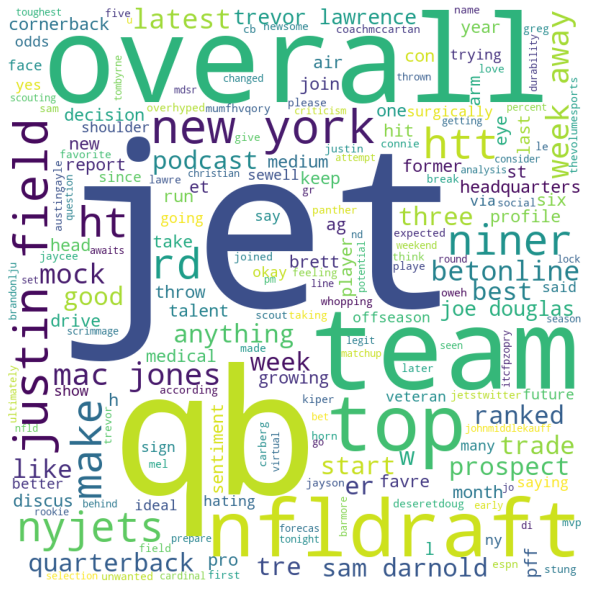

In [283]:
# CREATE WORD CLOUD

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(Tweet_DF['clean_text'].to_string())


plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [284]:
# IMPORT AFINN MODEL TO EVALUATE POSTIIVE NEGATIVE SENTIMENT OF RAW TWEETS

from afinn import Afinn


# SET AFINN DEFAULT AS ENGLISH
afinn = Afinn(language = 'en')

In [285]:
def AFINN(data):

    afin_lst = []



    for word in Tweet_DF['clean_text']:
        
        # NORMALIZE FOR TWEET LENGTH 
        adj_AFINN = (afinn.score(word)/ len(word.split()))
        afin_lst.append(adj_AFINN)


    return afin_lst

Tweet_DF['AFINN'] = AFINN(Tweet_DF)

In [286]:
# VADER SENTIMENT  - IMPORT LIBS

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [287]:
# VADER FUNCTION

def Vaderize(data):
    Vader_sentiment = data['Text'].apply(analyzer.polarity_scores)
    Vader_df = pd.DataFrame(Vader_sentiment.tolist())

    return Vader_df

In [288]:
# COMBINE DFS

Final_DF = pd.concat([Tweet_DF, Vaderize(Tweet_DF)], axis = 1)

Final_DF.head()



,Text,Favorite_count,Retweet_count,Date,Verified,Name,Screen Name,Followers,Hashtags,User_Desc,clean_text,AFINN,neg,neu,pos,compound
0,".@deseretdoug: Please, Jets, give Zach Wilson ...",2,0,Tue Apr 13 17:30:00 +0000 2021,True,Deseret News,DeseretNews,108163,[NFLDraft],"The Deseret News offers news, information, com...",deseretdoug please jet give break nfldraft htt...,0.111111,0.000,0.796,0.204,0.3182
1,According to @betonline_ag Zach Wilson is 80:1...,2,0,Tue Apr 13 16:52:43 +0000 2021,True,Kristian Dyer,KristianRDyer,12048,"[Jets, JetsTwitter]",NFL Draft Bible on @SINow. #Jets #RBNY #RFootb...,according betonline ag mvp jet jetstwitter,0.000000,0.000,1.000,0.000,0.0000
2,LOVE the decisions being made by the Social Me...,995,24,Tue Apr 13 15:47:09 +0000 2021,True,Pat McAfee,PatMcAfeeShow,2053581,[],Award winning wrestler. Kicked off a SuperBowl...,love decision made social medium team throw ma...,0.214286,0.000,0.817,0.183,0.7125
3,Mel Kiper’s latest mock draft for ESPN has the...,855,50,Tue Apr 13 12:17:13 +0000 2021,True,Brian Costello,BrianCoz,49919,[],New York Jets beat reporter for the New York P...,mel kiper latest mock espn jet taking qb cb gr...,-0.111111,0.109,0.891,0.000,-0.4215
4,New York Jets’ 2021 NFL Draft headquarters: Af...,0,0,Tue Apr 13 02:16:33 +0000 2021,True,The Athletic New York,TheAthleticNYC,15268,[],Here for every sports story that matters. \n📲 ...,new york jet headquarters keep eye cornerback ...,0.000000,0.000,1.000,0.000,0.0000


In [292]:
# RESULTS

Analysis_Pvt = round(pd.pivot_table(data=Final_DF, index= 'Verified' ,values=['neg','pos','compound', 'AFINN'], aggfunc='mean'),4)

Analysis_Pvt

,AFINN,compound,neg,pos
Verified,,,,
True,0.0369,0.0704,0.0329,0.0564


Text(0.5, 0, '')

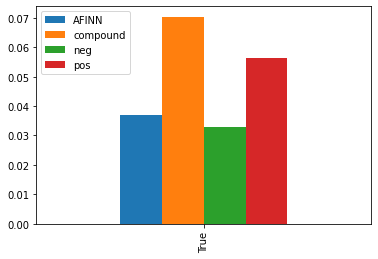

In [293]:
# VISUALIZE

Analysis_Pvt.plot(kind='bar')
plt.xlabel("")
